In [1]:
import numpy as np
import random
import math
from tqdm.notebook import tqdm
import pandas as pd
import torch
import torch.nn.functional as F
from gym import spaces
import matplotlib.pyplot as plt
from dataclasses import dataclass

/Users/valentinbrekke/miniconda3/lib/python3.10/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
from env import *
from SAC import *

In [3]:
env_param = dict(a=0.1, 
                T=1, 
                k=0.1, 
                Ux=0, 
                Uy=0, 
                alpha=1, 
                sigma=0, 
                x_goal=4, 
                y_goal=4, 
                pos0=np.array([0, 0, 0]), 
                theta0=0, 
                dist_threshold=0.2, 
                max_steps=200,
                ocean=False,
                dt=1,
                max_thrust_speed = 1,
                )

env = FluidMechanicsEnv(**env_param)

/Users/valentinbrekke/miniconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [26]:
@dataclass
class Args:
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    # Algorithm specific arguments
    total_timesteps: int = 100000
    """total timesteps of the experiments"""
    buffer_size: int = int(1e6)
    """the replay memory buffer size"""
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 0.005
    """target smoothing coefficient (default: 0.005)"""
    batch_size: int = 256
    """the batch size of sample from the reply memory"""
    learning_starts: int = 25000
    """timestep to start learning"""
    policy_lr: float = 3e-4
    """the learning rate of the policy network optimizer"""
    q_lr: float = 1e-3
    """the learning rate of the Q network network optimizer"""
    policy_frequency: int = 2
    """the frequency of training policy (delayed)"""
    target_network_frequency: int = 1  # Denis Yarats' implementation delays this by 2.
    """the frequency of updates for the target nerworks"""
    alpha: float = 0.2
    """Entropy regularization coefficient."""
    autotune: bool = True
    """automatic tuning of the entropy coefficient"""


In [27]:

# Seed everything for reproducibility
args = Args()
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.backends.cudnn.deterministic = args.torch_deterministic

# Create and train SAC agent
sac_agent = SAC(env, args)

policy, t, episode_num, smooth_reward, execution_time = sac_agent.train()


Step: 26000, QF Loss: 0.0016162156825885177
Step: 26000, Actor Loss: -0.16428902745246887
Step: 27000, QF Loss: 0.0038012871518731117
Step: 27000, Actor Loss: -0.07603026926517487
Step: 28000, QF Loss: 0.00524136470630765
Step: 28000, Actor Loss: -0.031177453696727753
Step: 29000, QF Loss: 0.006887404248118401
Step: 29000, Actor Loss: -0.005373066291213036
Step: 30000, QF Loss: 0.017401009798049927
Step: 30000, Actor Loss: 0.007344841957092285
Step: 31000, QF Loss: 0.004539682529866695
Step: 31000, Actor Loss: -0.005332557484507561
Step: 32000, QF Loss: 0.00039982201997190714
Step: 32000, Actor Loss: 0.024197237566113472
Step: 33000, QF Loss: 0.0023419824428856373
Step: 33000, Actor Loss: 0.019082829356193542
Step: 34000, QF Loss: 0.0012761785183101892
Step: 34000, Actor Loss: 0.009972823783755302
Step: 35000, QF Loss: 0.012025832198560238
Step: 35000, Actor Loss: -0.007979042828083038
Step: 36000, QF Loss: 0.6205872893333435
Step: 36000, Actor Loss: 0.012654795311391354
Step: 37000, Q

In [28]:
def plot_trajectory(policy):
    done = False
    obs = env.reset()
    x, y = [obs[0]], [obs[1]]

    while not done: 
        actions, _, _ = policy.get_action(torch.Tensor(obs).unsqueeze(0))
        actions = actions.detach().cpu().numpy()
        next_obs, rewards, sum_reward, terminations, steps_count, all_actions, = env.step(actions[0])
        x.append(next_obs[0])
        y.append(next_obs[1])
        obs = next_obs
        done = terminations
       
    fig = plt.figure(figsize = (10, 5))
    plt.grid(True)
    plt.scatter([env.x_goal], [env.y_goal], marker = "o", color = "r")
    plt.plot(x, y, 'k-o')
    plt.show()

def plot_reward(smooth_reward):
    # Plot cumulative rewards
    plt.figure(figsize=(10, 5))
    plt.plot(smooth_reward)
    plt.title("Cumulative Rewards Over Time SAC")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.grid(True)
    plt.show()

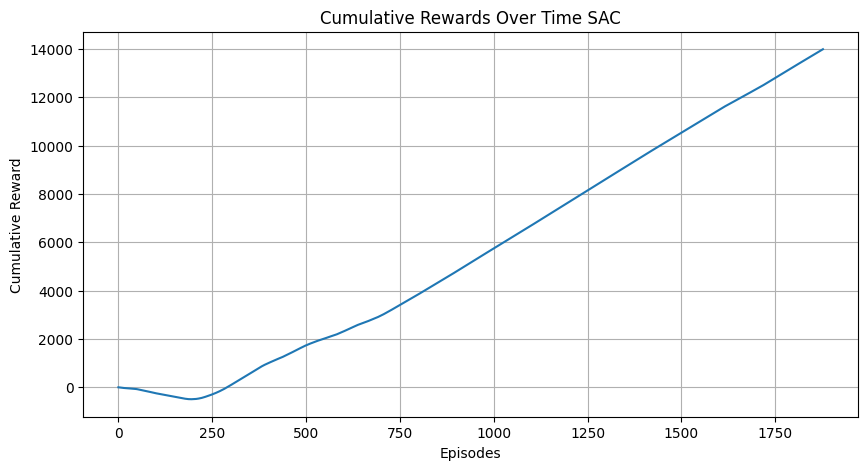

In [29]:
plot_reward(smooth_reward)

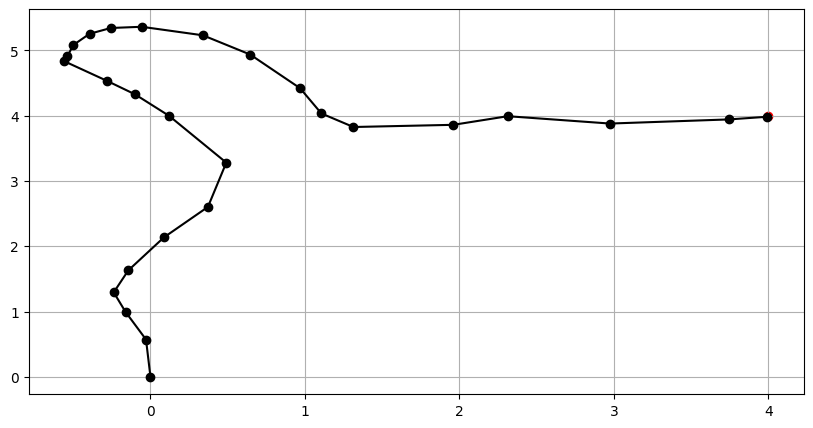

In [30]:
plot_trajectory(policy)